<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

# 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [3]:
if is_runing_into_colab_env():
    !pip install mne

# 2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/dataset`.

In [4]:
filename     = "procesados-20210908T224817Z-001.zip"
dataset_url  =  f'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/{filename}'
dataset_path = "dataset"

if is_runing_into_colab_env():
    !cd ~
    !rm -rf procesados
    !rm -rf dataset
    !rm -rf {filename}
    !wget  {dataset_url}
    !unzip {filename}
    !mv procesados dataset
    !apt install -y tree
    clear_output()
    !tree dataset

# 3. Importa libreria del proyecto

In [5]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp'):
        print('Pull...\n')
        !cd dm-cyt-tp; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp.git

In [6]:
sys.path.append('/content/dm-cyt-tp/src' if is_runing_into_colab_env() else './src')

# 4. Importa paquetes externos

In [7]:
import matplotlib.pylab as plt 

import numpy as np
import pandas as pd

from scipy.signal import find_peaks
from sklearn.cluster import KMeans

from plot import extraction_gfp, \
                 plot_gfp, \
                 plot_eeg_pca, \
                 plot_eeg_topology_on_axis, \
                 plot_egg_on_axis, \
                 plot_eegs_summary

from eeg       import get_info_eeg_and_montage, eegs_total_mean
from read_eeg  import load_eeg_dataset

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo de la señal orginal es de 256 Hz, luego fue filtrada y resampleada a 128 Hz.

## 5. Lectura de EEG's

Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"

In [8]:
eegs = load_eeg_dataset('./dataset/*')

In [9]:
eegs[0].to_dict()

{'subject': '9',
 'resting_state': '1',
 'nchannels': 30,
 'sfrequency': 128,
 'nsamples': 7681,
 'data': array([[ 1.616  , -0.24897,  2.1471 , ..., -0.22272,  4.0591 , -1.7013 ],
        [-1.4653 , -2.1064 ,  1.8991 , ..., -2.5467 ,  7.479  , -4.1234 ],
        [-3.7501 , -3.2131 ,  0.54613, ..., -3.9687 ,  8.9219 , -5.7996 ],
        ...,
        [-8.728  , -9.0875 , -1.7395 , ..., -5.642  ,  5.1158 , -8.1424 ],
        [-7.7983 , -6.0041 ,  1.8113 , ..., -4.8075 ,  4.5658 , -6.6284 ],
        [-3.9895 , -1.6225 ,  5.0169 , ..., -2.4491 ,  1.9292 , -3.6368 ]])}

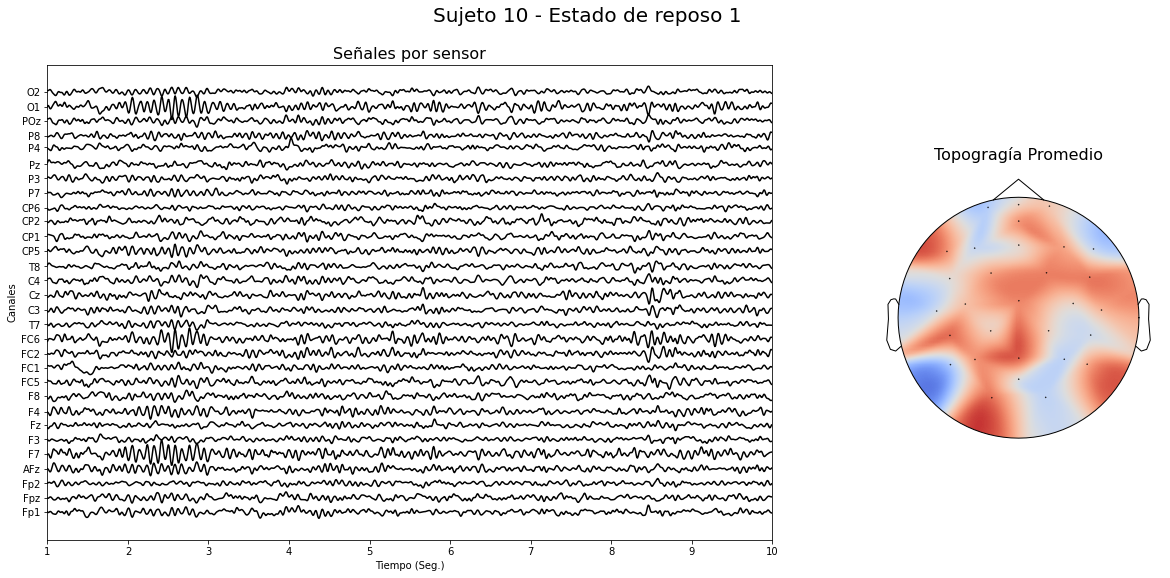

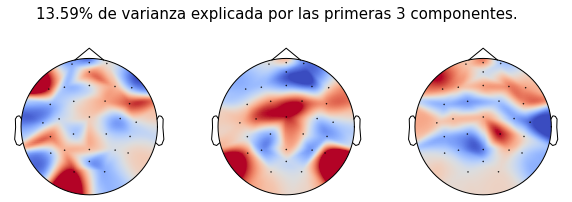

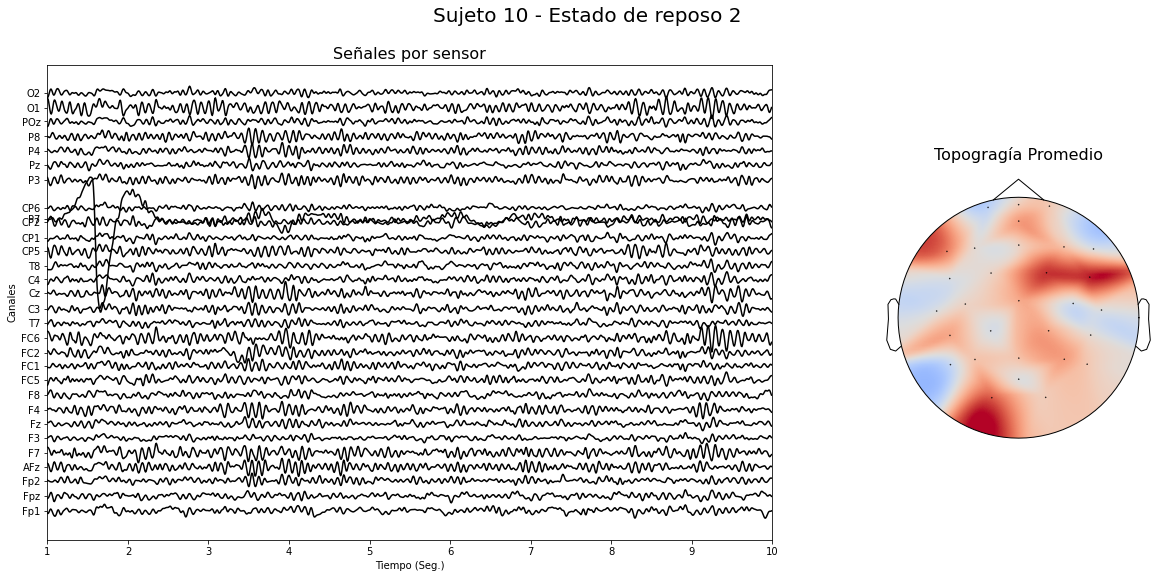

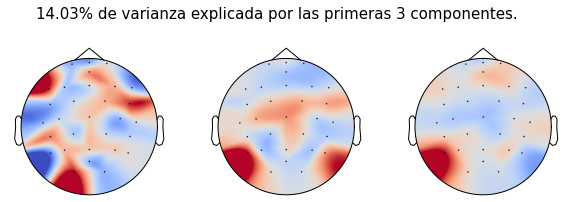

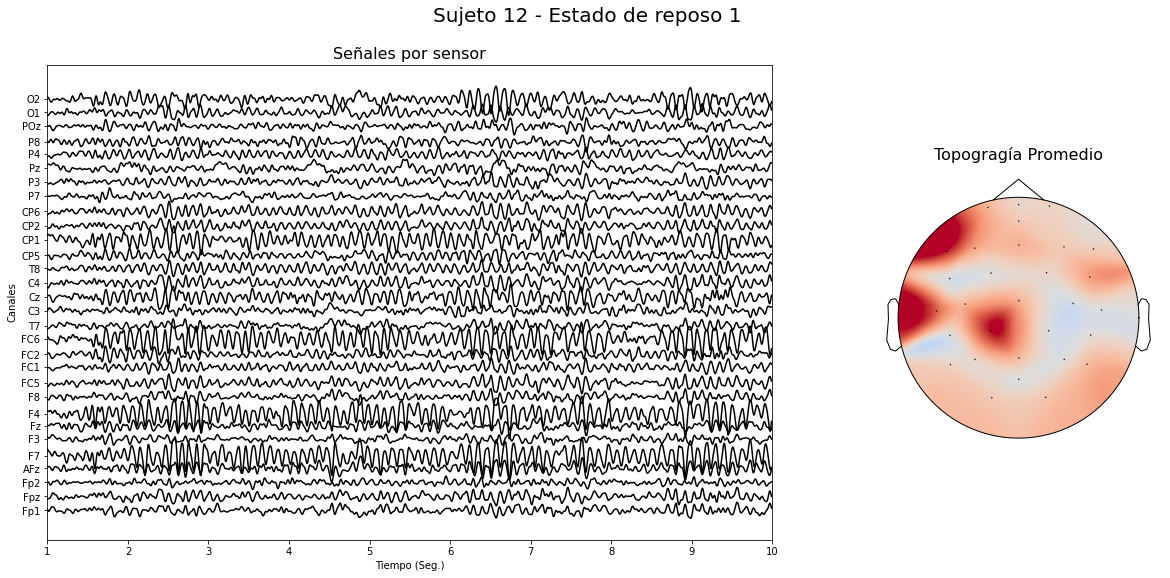

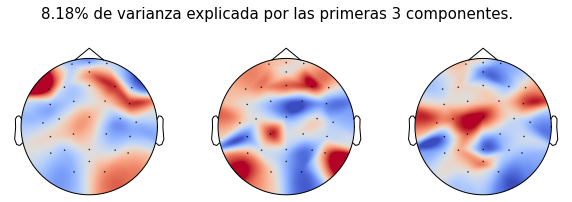

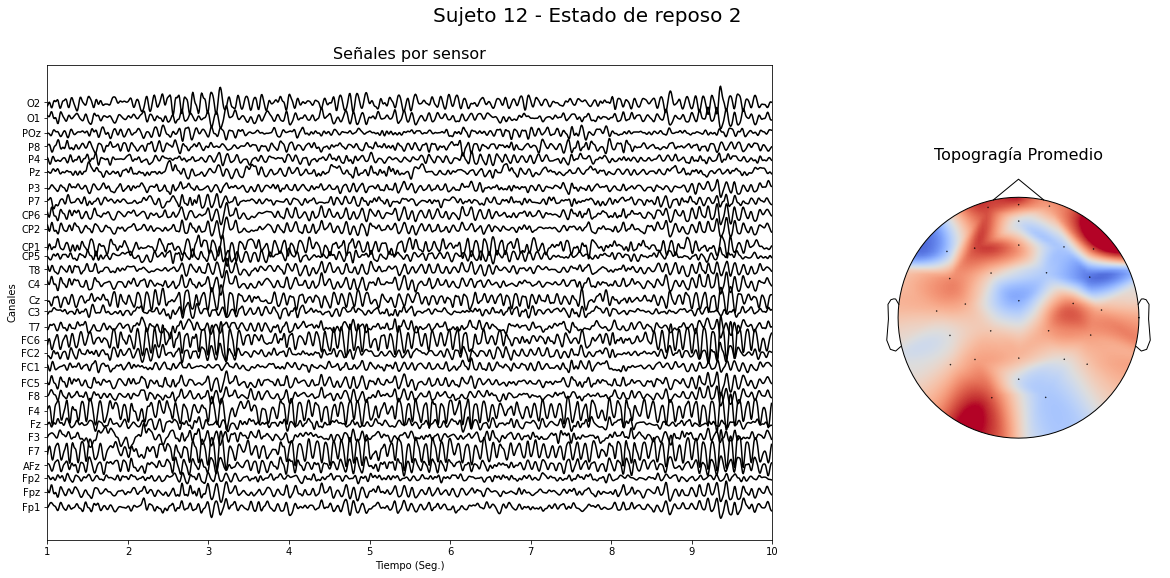

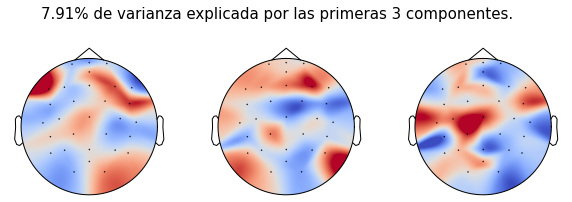

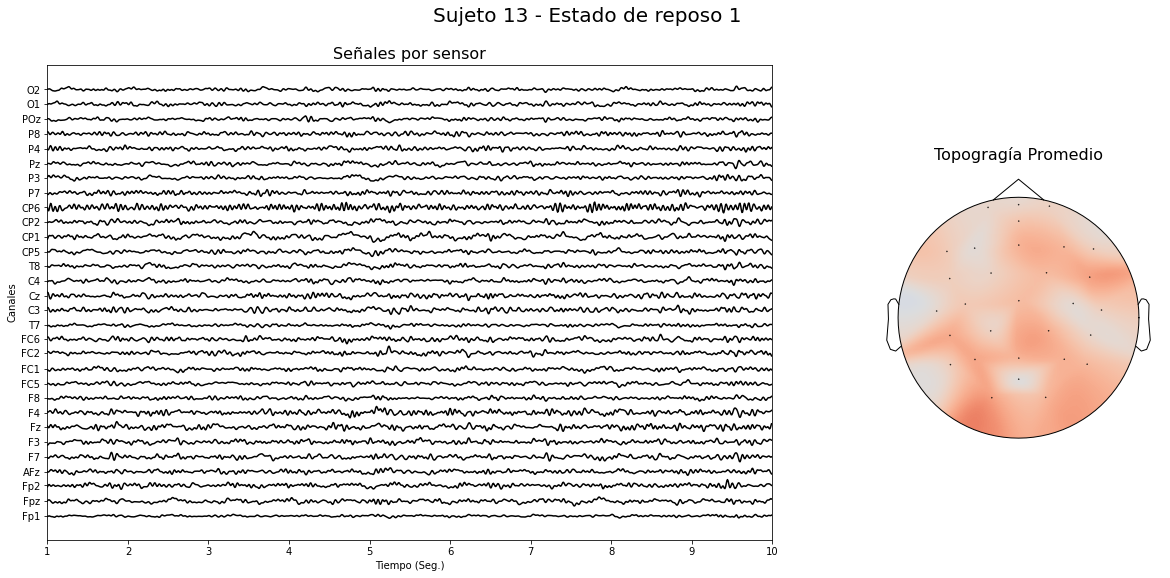

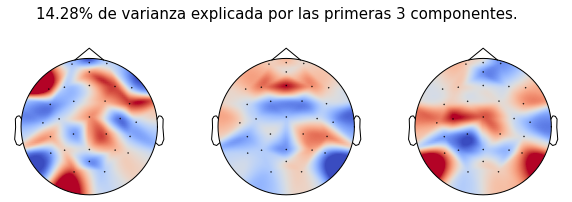

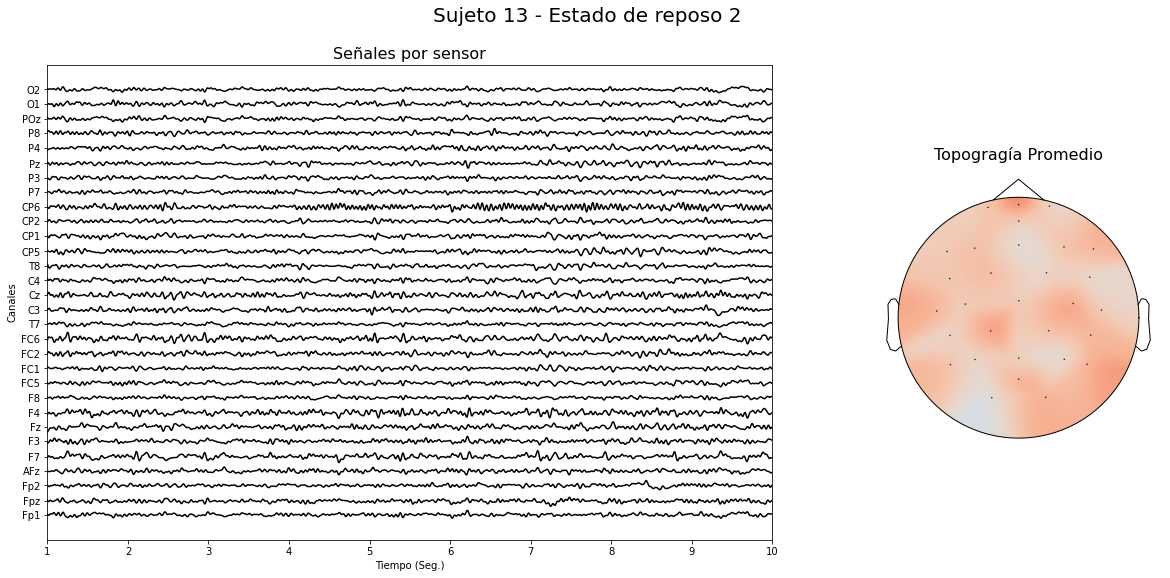

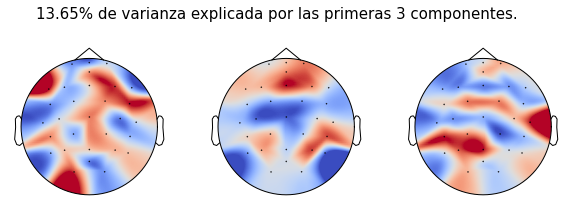

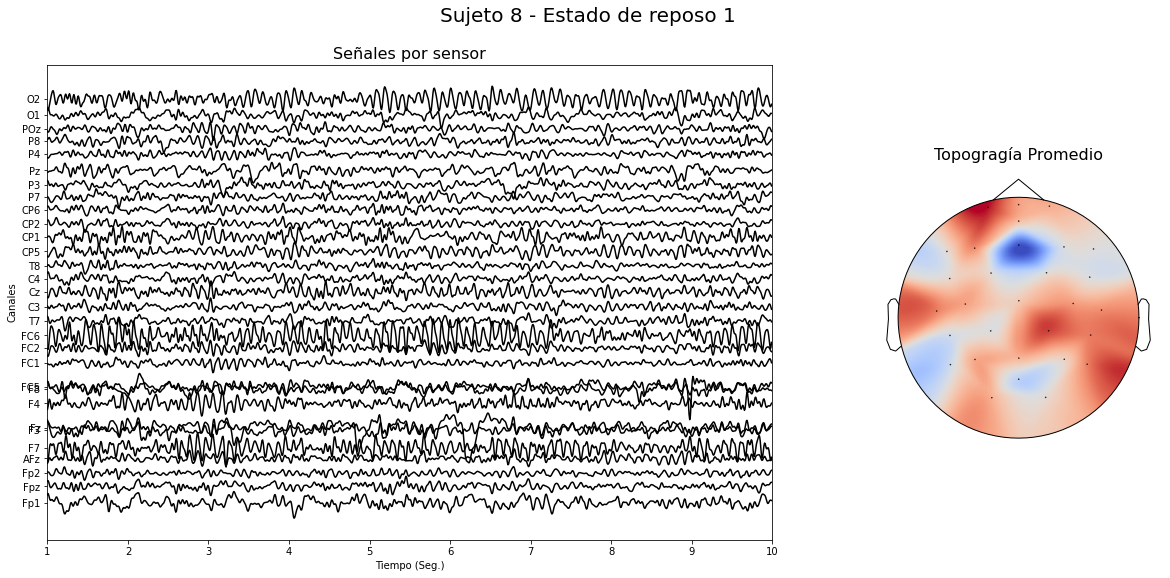

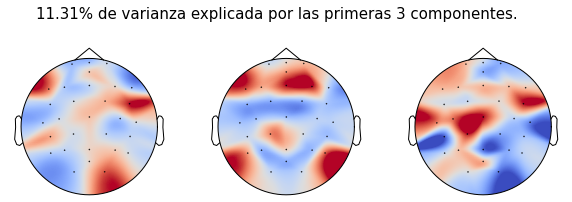

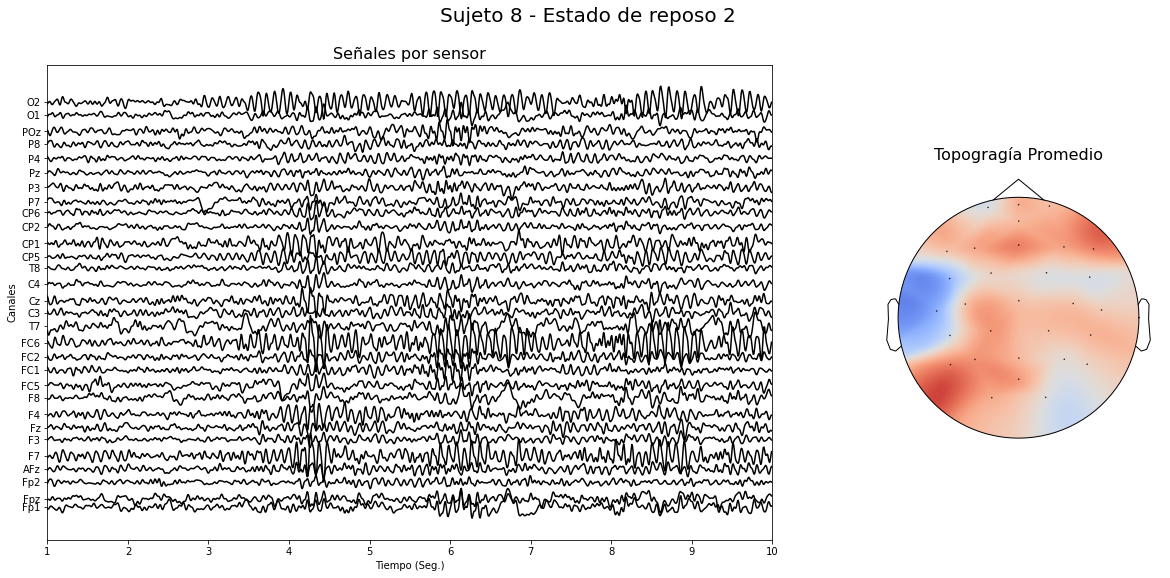

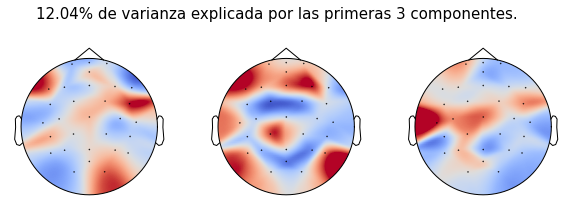

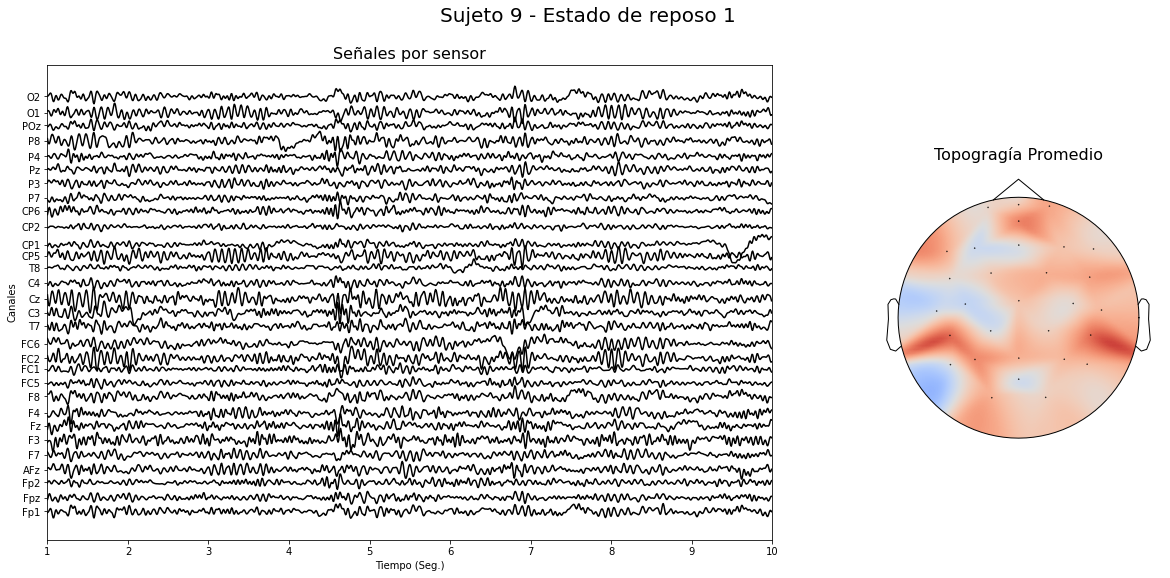

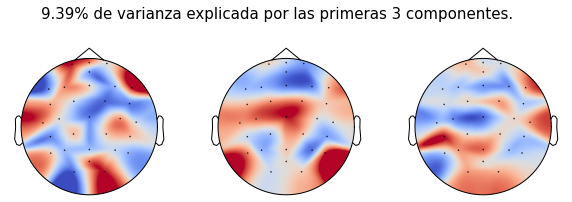

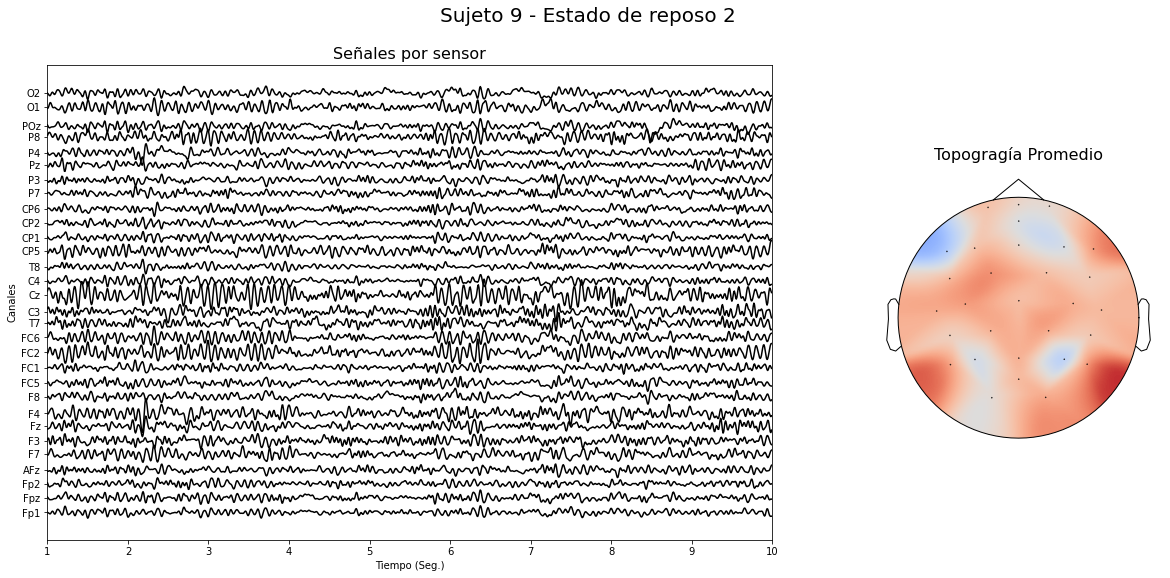

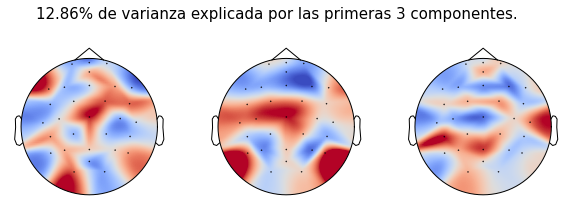

In [10]:
info_eeg, montage = get_info_eeg_and_montage()

plot_eegs_summary(eegs, info_eeg, montage)

In [11]:
promedios_totales = eegs_total_mean(eegs)

print(promedios_totales.max(axis=None))
print(promedios_totales.min(axis=None))

0.34050090885416645
-0.5493210911458327


In [12]:
datos_orig = np.empty((0, len(montage.ch_names) + 2))  #30 canales + 2 metadata individuo y tipo de reposo
datos_orig.shape

(0, 32)

Los registros fueron tomados con el montage 10-20.

**La nariz es fpz**.
Tengo que armarlo que los electrodos tengan esta distribución:
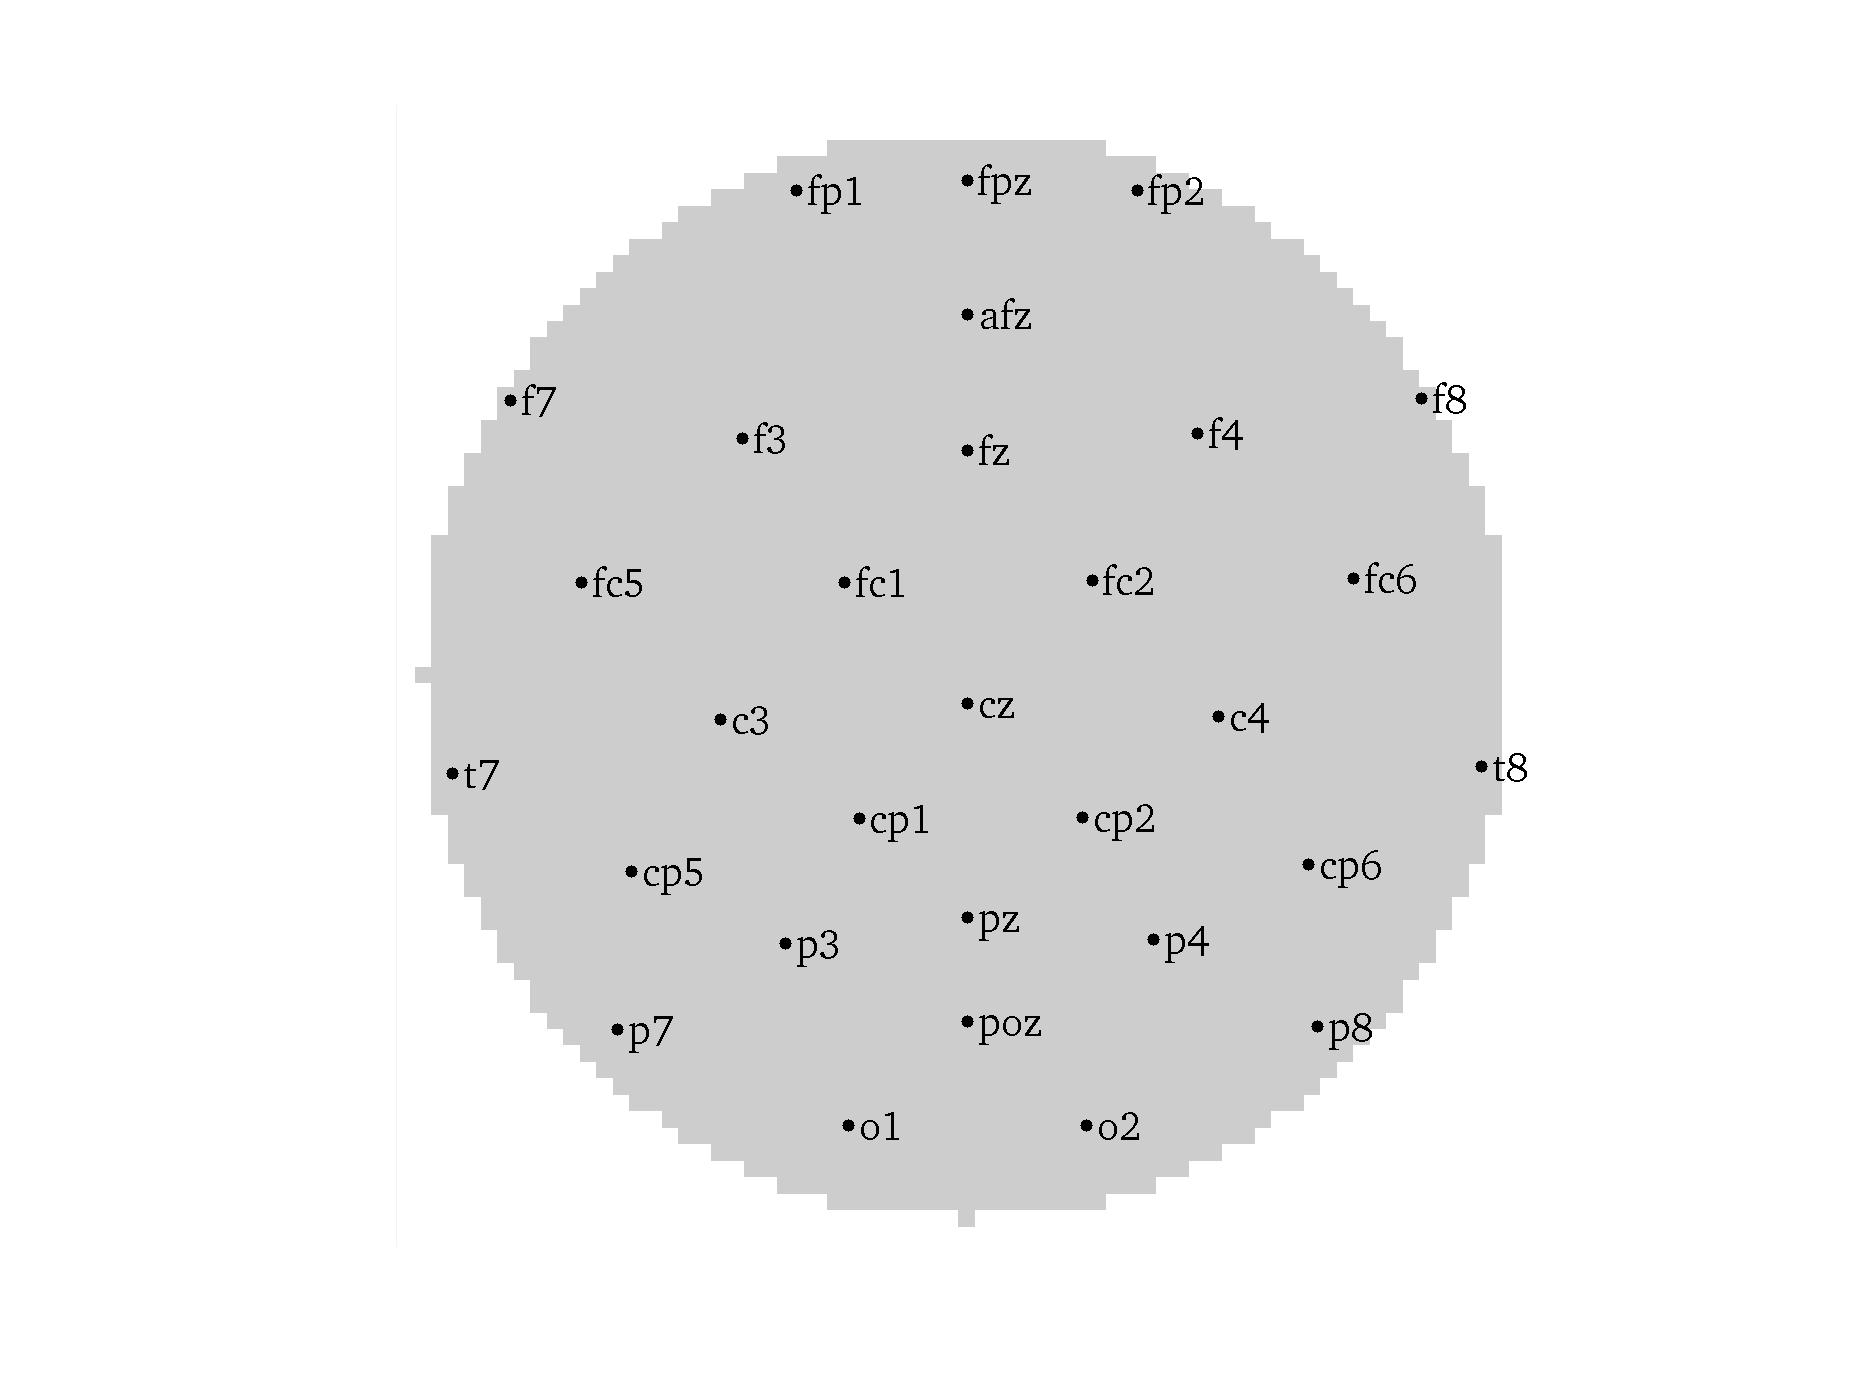

# 6. Inspección de EEG's procesados

Para los cálculos a continuación uso ref https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf.

Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{u_{i}}$   donde $c$ es la cantidad total de canales y $u_{i}$ es la medición del i-ésimo canal.

El *average reference* se calcula $v_i=u_i-\bar{u}$ \\
El *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}v_{i}^2}$ (para cada tiempo *t* o muestra *n*).
Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=8 y con la frecuencia de muestreo de 128 Hz los picos deberán estar alejados en no menos de 60 ms (aproximadamente).

Para cada indice identificados del máximo de GCP se calcula cuanto vale $v_{i}$.

In [13]:
eeg = eegs[0]
eeg.data.shape

(7681, 30)

In [14]:
gfp,peaks,v_i_peaks=extraction_gfp(eeg, 1, 8, 0)

Cantidad de picos de GFP: 569
El intervalo temporal entre máximos de GFP promedio es: 0.1054137323943662 ms
El intervalo temporal entre máximos de GFP más chico es: 0.0625 ms
El intervalo temporal entre máximos de GFP más grande es: 0.296875 ms


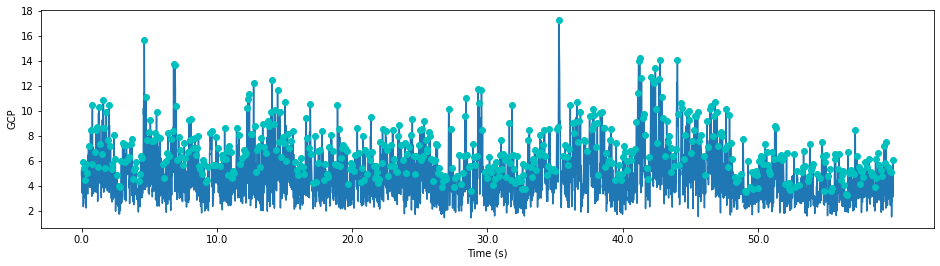

In [15]:
t = np.arange(0, eeg.data.shape[0]/eeg.sfrequency, 1/eeg.sfrequency)
plot_gfp(gfp, peaks, t)

In [16]:
data = np.transpose(v_i_peaks)
data.shape

(569, 30)

In [17]:
df = pd.DataFrame(data, columns=montage.ch_names)

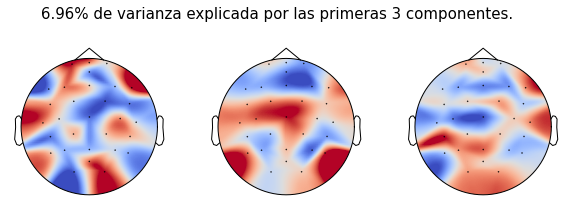

In [18]:
plot_eeg_pca(info_eeg, np.transpose(df))

In [19]:
#KMeans(n_clusters=6, random_state=0).fit(df)